# BioImage Model Zoo Example notebook

This notebook provides examples of how to load pretrained deep learning models from [BioImage Model Zoo](https://bioimage.io) and use them to process new images.

## **1. Install key dependencies**
---
<font size = 4>


### **1.0. Install required dependencies**

In [ ]:
#@markdown ##Play to install dependencies
#@markdown #### DO NOT RESTART THE SESSION UNTIL THE CELL FINISHES RUNNING
#@markdown #### This may take few minutes

!pip install bioimageio.core==0.5.11
!pip install matplotlib==3.5.3
!pip install imageio==2.31.2
!pip install numpy==1.23.5
!pip install torch==2.2.0
!pip install pooch==1.8

### **1.1. Load BioImageIO dependencies**

In [ ]:
#@markdown ##Play to load the dependencies and functions

# BioImage Model Zoo
import os
from datetime import datetime

# If you'd rather read the warning messages, please comment the follwing two lines.
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from imageio import imread
import xarray as xr
import numpy as np
from bioimageio.core.resource_tests import test_model
from bioimageio.core import load_resource_description
from bioimageio.core import create_prediction_pipeline
from bioimageio.core.prediction import predict_image, predict_images
from bioimageio.core.resource_io.utils import resolve_source
from bioimageio.core.build_spec import build_model
import hashlib

import json
from pathlib import Path
import pooch
from ruamel.yaml import YAML

yaml = YAML(typ="safe")

COLLECTION_URL = "https://raw.githubusercontent.com/bioimage-io/collection-bioimage-io/gh-pages/collection.json"

collection_path = Path(pooch.retrieve(COLLECTION_URL, known_hash=None))

with collection_path.open() as f:

    collection = json.load(f)

model_urls = [entry["rdf_source"] for entry in collection["collection"] if entry["type"] == "model"]

model_rdfs = [yaml.load(Path(pooch.retrieve(mu, known_hash=None))) for mu in model_urls]

pytorch_models = [rdf for rdf in model_rdfs if "pytorch_state_dict" in rdf["weights"]]

## **2. Inspect a model from the BioImage Model Zoo**

Here we will guide you through the basic functionalities of the BioImageIO Python packaget to interact with the content in the BioImage Model Zoo. General parameters to modify along the following cell.

In [4]:
#@markdown ##Check the models that can be loaded for PyTorch

# nickname_list = []
print('List of models for PyTorch:\n')

for model in pytorch_models:
    # nickname_list.append(model['config']['bioimageio']['nickname'])
    print(f"{model['name']}\n - {model['config']['bioimageio']['nickname']}\n - {model['config']['bioimageio']['doi']}")

List of models for PyTorch:

NucleiSegmentationBoundaryModel
 - affable-shark
 - 10.5281/zenodo.6647674
LiveCellSegmentationBoundaryModel
 - hiding-tiger
 - 10.5281/zenodo.6647688
Neuron Segmentation in EM (Membrane Prediction)
 - impartial-shrimp
 - 10.5281/zenodo.5874742
EnhancerMitochondriaEM2D
 - hiding-blowfish
 - 10.5281/zenodo.6811922
MitochondriaEMSegmentationBoundaryModel
 - kind-seashell
 - 10.5281/zenodo.6630266
PlatynereisEMnucleiSegmentationBoundaryModel
 - organized-badger
 - 10.5281/zenodo.6028098
PlatynereisEMcellsSegmentationBoundaryModel
 - willing-hedgehog
 - 10.5281/zenodo.6647695
3D UNet Arabidopsis Apical Stem Cells
 - emotional-cricket
 - 10.5281/zenodo.7768142
CovidIFCellSegmentationBoundaryModel
 - powerful-chipmunk
 - 10.5281/zenodo.6647683
MitchondriaEMSegmentation2D
 - shivering-raccoon
 - 10.5281/zenodo.6406804
3D UNet Mouse Embryo Live
 - powerful-fish
 - 10.5281/zenodo.7774490
3D UNet Mouse Embryo Fixed
 - loyal-squid
 - 10.5281/zenodo.7774505
EpitheliaAf

### **2.1. Load the resource description specifications of the model**

<font size = 2>**`BMZ_MODEL_ID`**: Unique identifier of the model to load in the BioImage Model Zoo, e.g., `impartial-shrimp`. These identifiers are given on each model card in the zoo.

OR

<font size = 2>**`BMZ_MODEL_DOI`**: Model DOIs can also be used to load the models.

OR

<font size = 2>**`BMZ_MODEL_URL`**: URL to the main Zenodo repository as well as to the `rdf.yaml` file containing the resource description specifications can be used to load models as well.

In [72]:
#@markdown ##Load the model description with one of these options

BMZ_MODEL_ID = "affable-shark" #@param {type:"string"}
BMZ_MODEL_DOI = "" #@param {type:"string"}
BMZ_MODEL_URL = "" #@param {type:"string"}

# Load the model description
# ------------------------------------------------------------------------------

if BMZ_MODEL_ID != "":
    model = load_resource_description(BMZ_MODEL_ID)  # TODO: load from bioimageio id
    print(f"The model '{model.name}' with ID '{BMZ_MODEL_ID}' has been correctly loaded.")
elif BMZ_MODEL_DOI != "":
    model = load_resource_description(BMZ_MODEL_DOI)  # TODO: load from bioimageio id
    print(f"The model '{model.name}' with DOI '{BMZ_MODEL_DOI}' has been correctly loaded.")
elif BMZ_MODEL_URL != "":
    model = load_resource_description(BMZ_MODEL_URL)  # TODO: load from bioimageio id
    print(f"The model '{model.name}' with URL '{BMZ_MODEL_URL}' has been correctly loaded.")
else:
    print('Please specify a model ID, DOI or URL')

The model 'NucleiSegmentationBoundaryModel' with ID 'affable-shark' has been correctly loaded.


### **2.2. Discover the different components and features of the model**

The model 'NucleiSegmentationBoundaryModel' had the following properties and metadata

 Description Nucleus segmentation for fluorescence microscopy

 The authors of the model are [Author(name='Constantin Pape', affiliation='EMBL Heidelberg', email=<marshmallow.missing>, github_user=<marshmallow.missing>, orcid=<marshmallow.missing>)]
 and it is maintained by: [Maintainer(name='Constantin Pape', affiliation=<marshmallow.missing>, email=<marshmallow.missing>, github_user='constantinpape', orcid=<marshmallow.missing>)]
 License: CC-BY-4.0

 If you use this model, you are expected to cite [CiteEntry(text='training library', doi=<marshmallow.missing>, url='https://doi.org/10.5281/zenodo.5108853'), CiteEntry(text='architecture', doi=<marshmallow.missing>, url='https://doi.org/10.1007/978-3-319-24574-4_28'), CiteEntry(text='segmentation algorithm', doi=<marshmallow.missing>, url='https://doi.org/10.1038/nmeth.4151'), CiteEntry(text='data', doi=<marshmallow.missing>, url='https://www.nature.c

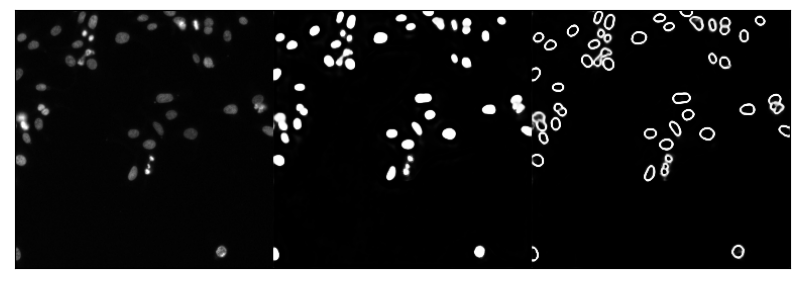

In [6]:
#@markdown ##Print information about the model

print(f"The model '{model.name}' had the following properties and metadata")
print()
print(f" Description {model.description}")
print()
print(f" The authors of the model are {model.authors}")
print(f" and it is maintained by: {model.maintainers}")
print(f" License: {model.license}")
print()

print(f" If you use this model, you are expected to cite {model.cite}")
print()
print(f" Further documentation can be found here: {model.cite}")
print()
print(f" GitHub repository: {model.git_repo}")
print()
print(f"Covers of the model '{model.name}'")
for cover in model.covers:
    cover_data = imread(cover)
    plt.figure(figsize=(10, 10))
    plt.imshow(cover_data)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [7]:
#@markdown ##Inspect the weights and, expected inputs and outputs

print("Available weight formats for this model:", model.weights.keys())
print("Pytorch state dict weights are locally stored at:", model.weights)
print()

# or what inputs the model expects
print(f"The model requires {len(model.inputs)} input(s) with the following features:")
for inp in model.inputs:
    print("Input with axes:", inp.axes, "and shape", inp.shape)
    print(f"It is expected to be processed with: {inp.preprocessing}")
print()
# and what the model outputs are
print(f"The model requires {len(model.outputs)} output(s) with the following features:")
for out in model.outputs:
    print("Output with axes:", out.axes, "and shape", out.shape)
    print(f"The output image has a halo of : {out.halo}")
    print(f"It is expected to be postprocessed with: {out.postprocessing}")

Available weight formats for this model: dict_keys(['onnx', 'pytorch_state_dict', 'torchscript'])
Pytorch state dict weights are locally stored at: {'onnx': OnnxWeightsEntry(authors=<marshmallow.missing>, attachments=<marshmallow.missing>, parent=<marshmallow.missing>, sha256='df913b85947f5132bcdaf81d91af0963f60d44f4caf8a4fec672d96a2f327b44', source=PosixPath('/tmp/root/bioimageio_cache/https/zenodo.org/api/records/6647674/files/weights.onnx'), opset_version=12, dependencies=<marshmallow.missing>), 'pytorch_state_dict': PytorchStateDictWeightsEntry(authors=<marshmallow.missing>, attachments=<marshmallow.missing>, parent=<marshmallow.missing>, sha256='608f52cd7f5119f7a7b8272395b0c169714e8be34536eaf159820f72a1d6a5b7', source=PosixPath('/tmp/root/bioimageio_cache/https/zenodo.org/api/records/6647674/files/weights.pt'), dependencies=Dependencies(manager='conda', file=PosixPath('/tmp/root/bioimageio_cache/https/zenodo.org/api/records/6647674/files/environment.yaml')), architecture=ImportedS

The model provides 1 test input image(s) :


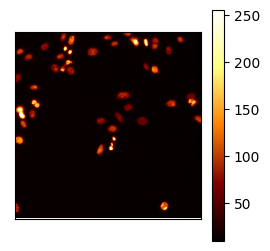

The model provides 1 test input image(s) :
The test output image has shape (2, 256, 256), so it will not displayed


In [8]:
#@markdown ##Inspect the test images

print(f"The model provides {len(model.test_inputs)} test input image(s) :")
for test_im in model.test_inputs:
    test_input = np.squeeze(np.load(test_im))
    if len(test_input.shape)>2:
        print(f"The test input image has shape {test_input.shape}, so it will not displayed")
    else:
        plt.figure(figsize=(3,3))
        plt.imshow(test_input, cmap="afmhot")
        plt.colorbar()
        plt.xticks([])
        plt.yticks([])
        plt.show()

# Inspect the test output images
print(f"The model provides {len(model.test_outputs)} test input image(s) :")
for test_im in model.test_outputs:
    test_output = np.squeeze(np.load(test_im))
    if len(test_output.shape)>2:
        print(f"The test output image has shape {test_output.shape}, so it will not displayed")
    else:
        plt.figure(figsize=(3,3))
        plt.imshow(test_output, cmap="afmhot")
        plt.colorbar()
        plt.xticks([])
        plt.yticks([])
        plt.show()

## **3. Test the model**

Both the model format and the deployment of the model can be tested. First we can run a static validation to check that the model follows the format of the BioImage Model Zoo correctly.

Then, we can check that it actually produces the output that is expected to produce, which is called dynamic validation. The latter is done by running a prediction for the test input images and checking that they agree with the test output(s). The running time this time will depend on the resources available (e.g., GPU acceleration).

In [9]:
#@markdown ##Check if the model pass the test

# 'test_model' returns a dict with 'status'='passed'/'failed' and more detailed information

for test_result in test_model(model):
    if test_result["status"] == "failed":
        print("model test:", test_result["name"])
        print("The model test failed with:", test_result["error"])
        print("with the traceback:")
        print("".join(test_result["traceback"]))
    else:
        print("model test:", test_result["name"])
        test_result["status"] == "passed"
        print("The model passed the test.")
        print()
print(f"The modle was tested using:")
print(f"'bioimageio_spec_version': '{test_result['bioimageio_spec_version']}'")
print(f"'bioimageio_core_version': '{test_result['bioimageio_core_version']}'")


computing dataset statistics: 0it [00:00, ?it/s]


model test: load resource description
The model passed the test.

model test: has expected resource type
The model passed the test.

model test: All URLs and paths available
The model passed the test.

model test: Test documentation completeness.
The model passed the test.

model test: reproduce test outputs from test inputs (bioimageio.core 0.5.11)
The model passed the test.

The modle was tested using:
'bioimageio_spec_version': '0.4.9post5'
'bioimageio_core_version': '0.5.11'


## **4. Use the model with new images**

The BioImageIO library includes functions to run prediction with `xarray.DataArrays` or on images stored on disc.

### **4.1. Process an input array**

The prediction pipeline expects inputs as `xarray.DataArrays`, which are similar to `numpy` arrays, but allow for named dimensions (the dims keyword argument).
In bioimage.io the dims have to agree with the input axes required by the model

computing dataset statistics: 0it [00:00, ?it/s]


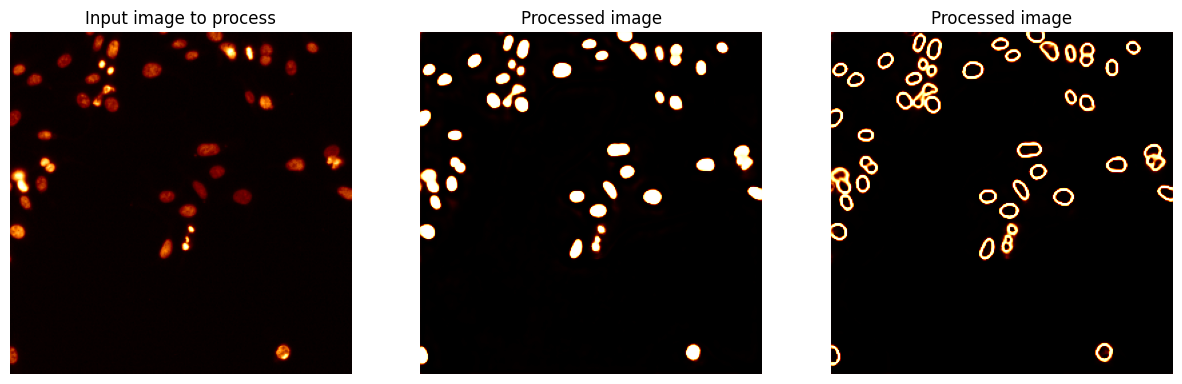

In [10]:
#@markdown ##Process the input within the model

# load the example image for this model, which is stored in numpy file format
input_image = np.load(model.test_inputs[0])

# "devices" can be used to run prediction on a gpu instead of the cpu
devices = None
# "weight_format" to specify which weight format to use in case the model contains different weight formats
weight_format = None
# the prediction pipeline combines preprocessing, prediction and postprocessing.
# it should always be used for prediction with a bioimageio model
pred_pipeline = create_prediction_pipeline(
    bioimageio_model=model, devices=devices, weight_format=weight_format
)
# the prediction pipeline expects inputs as xarray.DataArrays.
axes = tuple(model.inputs[0].axes)
input_tensor = xr.DataArray(input_image, dims=axes)

# the prediction pipeline call expects the same number of inputs as the number of inputs required by the model
# in the case here, the model just expects a single input. in the case of multiple inputs use
# prediction = pred_pipeline(input1, input2, ...)
# or, if you have the inputs in a list or tuple
# prediction = pred_pipeline(*inputs)
# the call returns a list of output tensors, corresponding to the output tensors of the model
# (in this case, we just have a single output)
prediction = pred_pipeline(input_tensor)[0]

prediction = np.squeeze(prediction)

if len(prediction.shape)>2:
    subplot_n = prediction.shape[0]
    plt.figure(figsize=(15,10))
    plt.subplot(1,1+subplot_n,1)
    plt.imshow(np.squeeze(input_image), cmap="afmhot")
    plt.axis('off')
    plt.title("Input image to process")

    for i in range(subplot_n):
        plt.subplot(1,1+subplot_n,i+2)
        plt.imshow(np.squeeze(prediction[i]), cmap="afmhot")
        plt.axis('off')
        plt.title("Processed image")
    plt.show()
else:
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(input_image), cmap="afmhot")
    plt.axis('off')
    plt.title("Input image to process")
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(prediction), cmap="afmhot")
    plt.axis('off')
    plt.title("Processed image")
    plt.show()

### **4.2 Process an image from a directory and save the result**

The BioImageIO is equipped with the utility function `predict_image` to run prediction with an image stored on disc. The filepath where the output should be stored (`save_outputs`), supports most common image formats as well as `npy` fileformat.

computing dataset statistics: 0it [00:00, ?it/s]


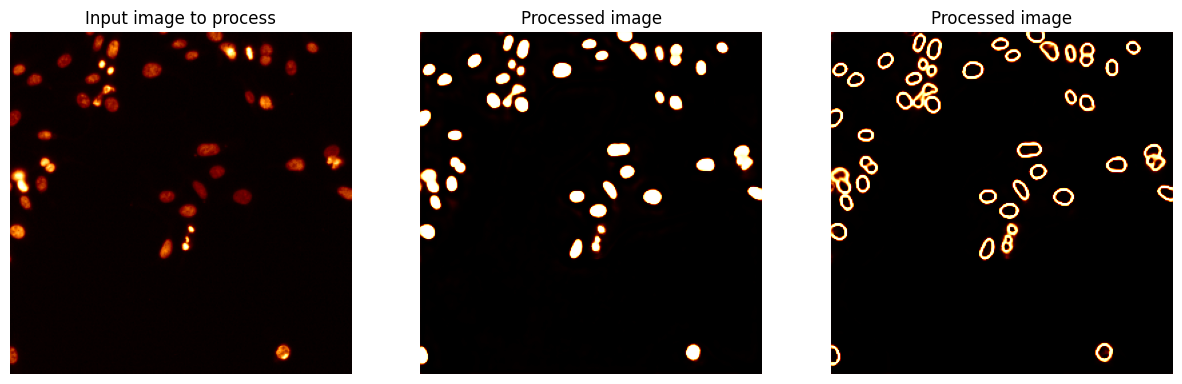

In [11]:
#@markdown ##Indicate the path to the image

# path + name of the stored output
use_test_image = True #@param {type:"boolean"}
#@markdown ### If you have an image in a folder to segment, copy the path to it here:
path2image = ""  #@param {type:"string"}
#@markdown ### Indicate where to save the output of the model:s
save_outputs = "/content/prediction.tif"  #@param {type:"string"}

if use_test_image:
  path2image = model.test_inputs

# model resource, the image that will be process, path to store the output
predict_image(model, path2image, [save_outputs])

# the output tensor contains 2 channels, which is not supported by normal tif.
# thus, these 2 channels are stored as 2 separate images


## Check the number of channels in the ouput and needed images to read
for test_im in model.test_outputs:
    test_output = np.squeeze(np.load(test_im))
    if len(test_output.shape)>2:
      fg_pred = [f"{save_outputs[:-4]}-c{i}.{save_outputs[-3:]}" for i in range(test_output.shape[0])]
    else:
      fg_pred = [save_outputs]
fg_pred = [imread(f) for f in fg_pred]

if use_test_image:
  input_image = np.load(model.test_inputs[0])
else:
  input_image = np.squeeze(imread(path2image))

plt.figure(figsize=(15,15))
plt.subplot(1,1+len(fg_pred),1)
plt.imshow(np.squeeze(input_image), cmap="afmhot")
plt.axis('off')
plt.title("Input image to process")
k=2
for f in fg_pred:
  plt.subplot(1,1+len(fg_pred),k)
  plt.imshow(f, cmap="afmhot")
  plt.axis('off')
  plt.title("Processed image")
  k+=1
plt.show()


### **4.3 Process a set of images stored in a directory**
It is possible to provide a list of images to analyse and run the analysis automatically. In this analysis `padding` and `tiling` strategies are enabled.

In [ ]:
#@markdown ##Indicate a directory with images to analyse and a directory to save the images

im_dir = "" #@param {type:"string"}
results_dir = "" #@param {type:"string"}
os.makedirs(results_dir, exist_ok=True)

# Get the list of images to analyse and the same list to save the images
inputs = [os.path.join(im_dir,f) for f in os.listdir(im_dir) if not f.startswith('.')]
outputs = [os.path.join(results_dir, os.path.split(inp)[1]) for inp in inputs]

print(len(inputs), "images for prediction were found")

predict_images(model, inputs, outputs, verbose=False)

In [ ]:
#@markdown ## If the images are too big we can even choose a padding.

padding_x = 16 #@param {type:"integer"}
padding_y = 16 #@param {type:"integer"}

padding = {"x": padding_x, "y": padding_y, "mode": "dynamic"}
predict_images(model, inputs, outputs, padding=padding, verbose=False)

In [ ]:
#@markdown ## Instead of padding, you can also use tiling.

# here, we specify a tile size of 224 and a halo (= extension of tile on both sides)
# size of 16, which results in an effective tile shale of 256 = 224 + 2*16

tile_x = 224 #@param {type:"integer"}
tile_y = 224 #@param {type:"integer"}
halo_x = 16 #@param {type:"integer"}
halo_y = 16 #@param {type:"integer"}

tiling = {
    "tile": {"x": tile_x, "y": tile_y},
    "halo": {"x": halo_x, "y": halo_y},
}

predict_images(model, inputs, outputs, tiling=tiling, verbose=False)

## **5. Fine-tune an existing model (only for segmentation)**

### **5.1 Connect to your google drive to access training data**

In [6]:
#@markdown ## Run this cell to connect google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **5.2 Start the fine-tuning**

In [43]:
#@markdown ## Load the training functions

from marshmallow import missing
import torch
import tifffile
import numpy as np
import random
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MultiLabelSoftMarginLoss
from torch.nn.functional import one_hot
from torch.optim import Adam
from torch.utils.data import Dataset
from tqdm import tqdm
import time

def load_pytorch_model(model):
    weight_spec = model.weights.get("pytorch_state_dict")
    model_kwargs = weight_spec.kwargs
    joined_kwargs = {} if model_kwargs is missing else dict(model_kwargs)
    model_instance = weight_spec.architecture(**joined_kwargs)
    _devices = ["cuda" if torch.cuda.is_available() else "cpu"]

    print(_devices)
    if len(_devices) > 1:
        warnings.warn("Multiple devices for single pytorch model not yet implemented")
    model_instance.to(_devices[0])
    weights = model.weights.get("pytorch_state_dict")
    if weights is not None and weights.source:
        state = torch.load(weights.source, map_location=_devices[0])
        model_instance.load_state_dict(state)
    model_instance.eval()

    return model_instance


class SegmentationTrainDataset(Dataset):
    def __init__(self,  INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT, imagePaths, maskPaths, classes):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.classes = classes
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)

    def preprocess(self, im):
        norm_im = np.float32(im)
        return (norm_im - np.mean(norm_im)) / (np.std(norm_im) + 1.0e-6)

    def __getitem__(self, idx):
        # grab the image path from the current index
        image = tifffile.imread(self.imagePaths[idx])
        mask = tifffile.imread(self.maskPaths[idx])
        # we want to ensure that there are cells in the patch
        # without getting in an infinite loop
        # TODO: define a sampling function to remove the loop
        num_labels = 0
        k = 0
        while num_labels<(self.classes-1) and k<5:
          # Choose a random coordinate to crop a patch
          h = random.randint(1, image.shape[0]-INPUT_IMAGE_HEIGHT-1)
          w = random.randint(1, image.shape[1]-INPUT_IMAGE_WIDTH-1)
          mask_patch = mask[h:h+INPUT_IMAGE_HEIGHT, w:w+INPUT_IMAGE_WIDTH]
          num_labels = len(np.unique(mask_patch))
          # If the mask contains more than one label for semantic segmentation
          # we will trasnform into one-hot encoding
          mask_torch = torch.tensor(mask_patch).to(torch.int64)
          mask_hot = one_hot(mask_torch, self.classes)
          mask_hot = mask_hot[:,:,1:]
          if len(mask_hot.shape)==2:
            # add a dimension
            mask_hot = np.expand_dims(mask_hot, -1)
          # first axis goes to the channels
          mask_hot = np.transpose(mask_hot, [-1, 0, 1])
          k += 1
          # return a tuple of the image and its mask
        norm_image = self.preprocess(image)
        norm_image = np.expand_dims(norm_image[h:h+INPUT_IMAGE_HEIGHT, w:w+INPUT_IMAGE_WIDTH], 0)
        return (torch.tensor(norm_image).float(), torch.tensor(mask_hot).float())

class SegmentationTestDataset(Dataset):
    def __init__(self,  INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT, imagePaths, maskPaths, classes):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.classes = classes
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)

    def preprocess(self, im):
        norm_im = np.float32(im)
        return (norm_im - np.mean(norm_im)) / (np.std(norm_im) + 1.0e-6)

    def __getitem__(self, idx):
        # grab the image path from the current index
        image = tifffile.imread(self.imagePaths[idx])
        mask = tifffile.imread(self.maskPaths[idx])
        # no patches are cropped. Check for the memory
        mask_torch = torch.tensor(mask).to(torch.int64)
        mask_hot = one_hot(mask_torch, self.classes)
        mask_hot = mask_hot[:,:,1:]
        if len(mask_hot.shape)==2:
          # add a dimension
          mask_hot = np.expand_dims(mask_hot, -1)
        # first axis goes to the channels
        mask_hot = np.transpose(mask_hot, [-1, 0, 1])
        # return a tuple of the image and its mask
        norm_image = self.preprocess(image)
        norm_image = np.expand_dims(norm_image, 0)
        return (torch.tensor(norm_image).float(), torch.tensor(mask_hot).float())


def visualize_results(input_image, gt, prediction):
  if len(prediction.shape)>2:
      subplot_n = prediction.shape[0]
      plt.figure(figsize=(20,15))
      plt.subplot(1,1+2*subplot_n,1)
      plt.imshow(np.squeeze(input_image), cmap="gray")
      plt.axis('off')
      plt.title("Input test image")

      for i in range(subplot_n):
          plt.subplot(1,1+2*subplot_n,i+2)
          plt.imshow(np.squeeze(gt[i]), cmap="afmhot")
          plt.axis('off')
          plt.title("Ground truth image")

          plt.subplot(1,1+2*subplot_n,i+4)
          plt.imshow(np.squeeze(prediction[i]), cmap="afmhot")
          plt.axis('off')
          plt.title("Processed image")
      plt.show()
  else:
      plt.figure(figsize=(10,10))
      plt.subplot(1,3,1)
      plt.imshow(np.squeeze(input_image), cmap="afmhot")
      plt.axis('off')
      plt.title("Input test image")
      plt.subplot(1,3,2)
      plt.imshow(np.squeeze(gt), cmap="afmhot")
      plt.axis('off')
      plt.title("Ground truth image")

      plt.subplot(1,3,3)
      plt.imshow(np.squeeze(prediction), cmap="afmhot")
      plt.axis('off')
      plt.title("Processed image")
      plt.show()


def finetune_bioimageio_model(model, TRAIN_IM, TRAIN_MASK, TEST_IM, TEST_MASK,
                              BASE_OUTPUT, NUM_EPOCHS=100, INIT_LR=0.0001, BATCH_SIZE=10,
                              INPUT_IMAGE_WIDTH=512, INPUT_IMAGE_HEIGHT=512, CLASSES=3):

    model_instance = load_pytorch_model(model)
    # create the train and test datasets
    trainImages = sorted([os.path.join(TRAIN_IM, i) for i in os.listdir(TRAIN_IM) if i.endswith(".tif") ])
    trainMasks = sorted([os.path.join(TRAIN_MASK, i) for i in os.listdir(TRAIN_MASK) if i.endswith(".tif") ])
    testImages = sorted([os.path.join(TEST_IM, i) for i in os.listdir(TEST_IM) if i.endswith(".tif") ])
    testMasks = sorted([os.path.join(TEST_MASK, i) for i in os.listdir(TEST_MASK) if i.endswith(".tif") ])

    trainDS = SegmentationTrainDataset( INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT, imagePaths=trainImages, maskPaths=trainMasks, classes = CLASSES)
    testDS = SegmentationTestDataset( INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT, imagePaths=testImages, maskPaths=testMasks, classes = CLASSES)
    print(f"[INFO] found {len(trainDS)} examples in the training set...")
    print(f"[INFO] found {len(testDS)} examples in the test set...")

    # create the training and test data loaders
    from torch.utils.data import DataLoader

    # determine the device to be used for training and evaluation
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    # determine if we will be pinning memory during data loading
    PIN_MEMORY = True if DEVICE == "cuda" else False
    trainLoader = DataLoader(trainDS, shuffle=True, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY, num_workers=os.cpu_count())
    testLoader = DataLoader(testDS, shuffle=False, batch_size=1, pin_memory=PIN_MEMORY, num_workers=os.cpu_count())

    # initialize loss function and optimizer
    lossFunc = CrossEntropyLoss()
    opt = Adam(model_instance.parameters(), lr=INIT_LR)
    # calculate steps per epoch for training and test set
    trainSteps = len(trainDS) // BATCH_SIZE
    testSteps = len(testDS)
    # initialize a dictionary to store training history
    H = {"train_loss": [], "test_loss": []}

    # Save the initial prediction
    x, y = testDS.__getitem__(-1)
    x = x.unsqueeze(0)
    with torch.no_grad():
        # set the model in evaluation mode
        model_instance.eval()
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        # make the predictions
        pred = model_instance(x)

    input_image = x.to("cpu")
    input_image = np.squeeze(input_image.numpy())

    gt = y.to("cpu")
    gt = np.squeeze(gt.numpy())

    prediction = pred.to("cpu")
    prediction = np.squeeze(prediction.numpy())
    print("Results of the prediction before finetuning")
    print("---------------------------------------------")
    visualize_results(input_image, gt, prediction)
    print("---------------------------------------------")
    del x, y, gt, prediction, input_image, pred

    # loop over epochs
    print("[INFO] training the network...")
    startTime = time.time()
    for e in tqdm(range(NUM_EPOCHS)):
        # set the model in training mode
        model_instance.train()
        # initialize the total training and validation loss
        totalTrainLoss = 0
        totalTestLoss = 0
        # loop over the training set

        for (i, (x, y)) in enumerate(trainLoader):
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            # perform a forward pass and calculate the training loss
            pred = model_instance(x)
            loss = lossFunc(pred, y)
            # first, zero out any previously accumulated gradients, then
            # perform backpropagation, and then update model parameters
            opt.zero_grad()
            loss.backward()
            opt.step()
            # add the loss to the total training loss so far
            totalTrainLoss += loss
        # switch off autograd
        with torch.no_grad():
            # set the model in evaluation mode
            model_instance.eval()
            # loop over the validation set
            for (x, y) in testLoader:
                # send the input to the device
                (x, y) = (x.to(DEVICE), y.to(DEVICE))
                # make the predictions and calculate the validation loss
                pred = model_instance(x)
                totalTestLoss += lossFunc(pred, y)
        if DEVICE=="cuda":
            torch.save(model_instance.state_dict(),
                       os.path.join(BASE_OUTPUT, "finetuned_last.pth"))
        else:
            torch.save(model_instance.cpu().state_dict(),
                       os.path.join(BASE_OUTPUT, "finetuned_last.pth"))

        # calculate the average training and validation loss
        avgTrainLoss = totalTrainLoss / trainSteps
        avgTestLoss = totalTestLoss / testSteps
        # update our training history
        H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
        H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
        # print the model training and validation information
        print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
        print("Train loss: {:.6f}, Test loss: {:.4f}".format(
            avgTrainLoss, avgTestLoss))
    # display the total time needed to perform the training
    endTime = time.time()
    print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

    input_image = x.to("cpu")
    input_image = np.squeeze(input_image.numpy())

    gt = y.to("cpu")
    gt = np.squeeze(gt.numpy())

    prediction = pred.to("cpu")
    prediction = np.squeeze(prediction.numpy())

    visualize_results(input_image, gt, prediction)

    return model_instance, H

# get the python file defining the architecture.
# this is only required for models with pytorch_state_dict weights
def get_architecture_source(rdf):
    import bioimageio
    # here, we need the raw resource, which contains the information from the resource description
    # before evaluation, e.g. the file and name of the python file with the model architecture
    raw_resource = bioimageio.core.load_raw_resource_description(rdf)
    # the python file defining the architecture for the pytorch weihgts
    model_source = raw_resource.weights["pytorch_state_dict"].architecture
    # download the source file if necessary
    source_file = bioimageio.core.resource_io.utils.resolve_source(
        model_source.source_file
    )
    # if the source file path does not exist, try combining it with the root path of the model
    if not os.path.exists(source_file):
        source_file = os.path.join(raw_resource.root_path, os.path.split(source_file)[1])
    assert os.path.exists(source_file), source_file
    class_name = model_source.callable_name
    return f"{source_file}:{class_name}"

computing dataset statistics: 0it [00:00, ?it/s]


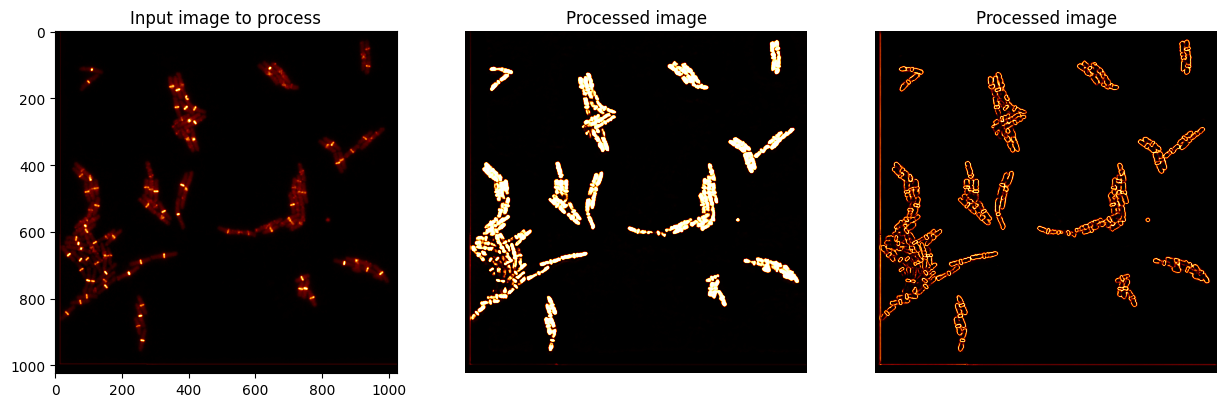

In [7]:
#@markdown ##Visualise the output of the model on an example image before fine-tuning.

path2image = "/content/Multilabel_U-Net_dataset_B.subtilis/test/source/test_9.tif"  #@param {type:"string"}
#@markdown ### Indicate where to save the output of the model:s
save_outputs = "/content/prediction.tif"  #@param {type:"string"}

# model resource, the image that will be process, path to store the output
predict_image(model, path2image, [save_outputs])

# the output tensor contains 2 channels, which is not supported by normal tif.
# thus, these 2 channels are stored as 2 separate images


## Check the number of channels in the ouput and needed images to read
for test_im in model.test_outputs:
    test_output = np.squeeze(np.load(test_im))
    if len(test_output.shape)>2:
      fg_pred = [f"{save_outputs[:-4]}-c{i}.{save_outputs[-3:]}" for i in range(test_output.shape[0])]
    else:
      fg_pred = [save_outputs]
fg_pred = [imread(f) for f in fg_pred]

input_image = np.squeeze(imread(path2image))
plt.figure(figsize=(15,15))
plt.subplot(1,1+len(fg_pred),1)
plt.imshow(np.squeeze(input_image), cmap="afmhot")
plt.title("Input image to process")
k=2
for f in fg_pred:
  plt.subplot(1,1+len(fg_pred),k)
  plt.imshow(f, cmap="afmhot")
  plt.axis('off')
  plt.title("Processed image")
  k+=1
plt.show()


['cuda']
[INFO] found 80 examples in the training set...
[INFO] found 10 examples in the test set...
torch.Size([1, 1, 1024, 1024])
Results of the prediction before finetuning
---------------------------------------------


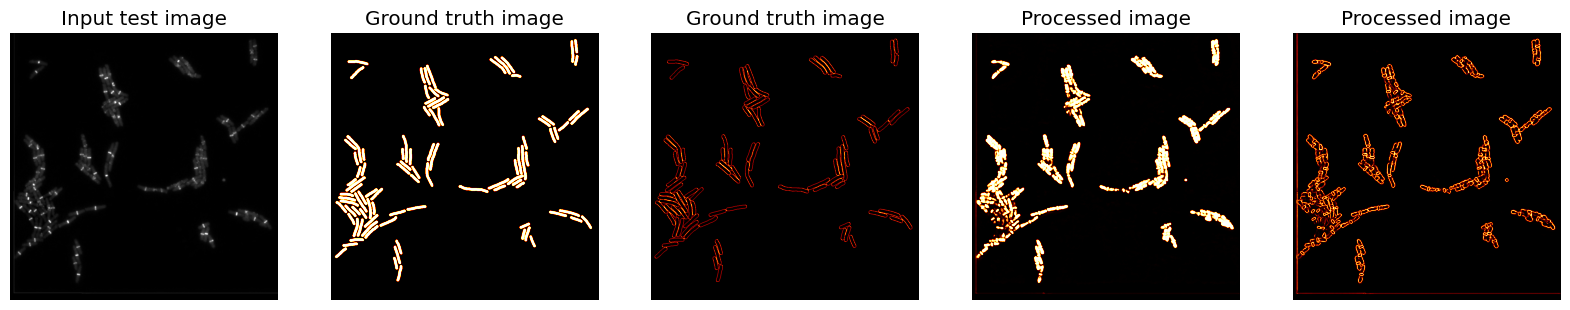

---------------------------------------------
[INFO] training the network...


  1%|          | 1/150 [00:09<23:22,  9.41s/it]

[INFO] EPOCH: 1/150
Train loss: 0.028589, Test loss: 0.0277


  1%|▏         | 2/150 [00:19<23:43,  9.62s/it]

[INFO] EPOCH: 2/150
Train loss: 0.021742, Test loss: 0.0276


  2%|▏         | 3/150 [00:29<23:54,  9.76s/it]

[INFO] EPOCH: 3/150
Train loss: 0.024787, Test loss: 0.0275


  3%|▎         | 4/150 [00:38<23:46,  9.77s/it]

[INFO] EPOCH: 4/150
Train loss: 0.026757, Test loss: 0.0273


  3%|▎         | 5/150 [00:48<23:45,  9.83s/it]

[INFO] EPOCH: 5/150
Train loss: 0.025014, Test loss: 0.0273


  4%|▍         | 6/150 [00:58<23:35,  9.83s/it]

[INFO] EPOCH: 6/150
Train loss: 0.022934, Test loss: 0.0272


  5%|▍         | 7/150 [01:08<23:34,  9.89s/it]

[INFO] EPOCH: 7/150
Train loss: 0.024152, Test loss: 0.0271


  5%|▌         | 8/150 [01:18<23:15,  9.82s/it]

[INFO] EPOCH: 8/150
Train loss: 0.024069, Test loss: 0.0271


  6%|▌         | 9/150 [01:28<23:07,  9.84s/it]

[INFO] EPOCH: 9/150
Train loss: 0.025379, Test loss: 0.0271


  7%|▋         | 10/150 [01:38<23:12,  9.95s/it]

[INFO] EPOCH: 10/150
Train loss: 0.023997, Test loss: 0.0270


  7%|▋         | 11/150 [01:48<23:07,  9.99s/it]

[INFO] EPOCH: 11/150
Train loss: 0.021250, Test loss: 0.0270


  8%|▊         | 12/150 [01:58<22:49,  9.92s/it]

[INFO] EPOCH: 12/150
Train loss: 0.026418, Test loss: 0.0270


  9%|▊         | 13/150 [02:08<22:37,  9.91s/it]

[INFO] EPOCH: 13/150
Train loss: 0.023828, Test loss: 0.0270


  9%|▉         | 14/150 [02:18<22:27,  9.91s/it]

[INFO] EPOCH: 14/150
Train loss: 0.024597, Test loss: 0.0269


 10%|█         | 15/150 [02:27<21:57,  9.76s/it]

[INFO] EPOCH: 15/150
Train loss: 0.027937, Test loss: 0.0269


 11%|█         | 16/150 [02:37<21:49,  9.77s/it]

[INFO] EPOCH: 16/150
Train loss: 0.023988, Test loss: 0.0269


 11%|█▏        | 17/150 [02:47<21:48,  9.84s/it]

[INFO] EPOCH: 17/150
Train loss: 0.023806, Test loss: 0.0269


 12%|█▏        | 18/150 [02:57<21:40,  9.85s/it]

[INFO] EPOCH: 18/150
Train loss: 0.025737, Test loss: 0.0268


 13%|█▎        | 19/150 [03:06<21:28,  9.84s/it]

[INFO] EPOCH: 19/150
Train loss: 0.026150, Test loss: 0.0268


 13%|█▎        | 20/150 [03:16<21:14,  9.80s/it]

[INFO] EPOCH: 20/150
Train loss: 0.025312, Test loss: 0.0268


 14%|█▍        | 21/150 [03:27<21:26,  9.97s/it]

[INFO] EPOCH: 21/150
Train loss: 0.023489, Test loss: 0.0268


 15%|█▍        | 22/150 [03:36<21:09,  9.92s/it]

[INFO] EPOCH: 22/150
Train loss: 0.025007, Test loss: 0.0267


 15%|█▌        | 23/150 [03:46<20:44,  9.80s/it]

[INFO] EPOCH: 23/150
Train loss: 0.026392, Test loss: 0.0267


 16%|█▌        | 24/150 [03:56<20:40,  9.85s/it]

[INFO] EPOCH: 24/150
Train loss: 0.020482, Test loss: 0.0267


 17%|█▋        | 25/150 [04:06<20:53, 10.02s/it]

[INFO] EPOCH: 25/150
Train loss: 0.022668, Test loss: 0.0267


 17%|█▋        | 26/150 [04:16<20:33,  9.95s/it]

[INFO] EPOCH: 26/150
Train loss: 0.022476, Test loss: 0.0267


 18%|█▊        | 27/150 [04:26<20:20,  9.92s/it]

[INFO] EPOCH: 27/150
Train loss: 0.022848, Test loss: 0.0267


 19%|█▊        | 28/150 [04:36<20:08,  9.90s/it]

[INFO] EPOCH: 28/150
Train loss: 0.024480, Test loss: 0.0267


 19%|█▉        | 29/150 [04:46<20:07,  9.98s/it]

[INFO] EPOCH: 29/150
Train loss: 0.024601, Test loss: 0.0267


 20%|██        | 30/150 [04:56<19:51,  9.93s/it]

[INFO] EPOCH: 30/150
Train loss: 0.021156, Test loss: 0.0267


 21%|██        | 31/150 [05:06<19:41,  9.93s/it]

[INFO] EPOCH: 31/150
Train loss: 0.023218, Test loss: 0.0267


 21%|██▏       | 32/150 [05:15<19:20,  9.83s/it]

[INFO] EPOCH: 32/150
Train loss: 0.023470, Test loss: 0.0267


 22%|██▏       | 33/150 [05:25<19:15,  9.88s/it]

[INFO] EPOCH: 33/150
Train loss: 0.022454, Test loss: 0.0267


 23%|██▎       | 34/150 [05:35<19:01,  9.84s/it]

[INFO] EPOCH: 34/150
Train loss: 0.021415, Test loss: 0.0267


 23%|██▎       | 35/150 [05:45<18:56,  9.88s/it]

[INFO] EPOCH: 35/150
Train loss: 0.023466, Test loss: 0.0267


 24%|██▍       | 36/150 [05:55<18:55,  9.96s/it]

[INFO] EPOCH: 36/150
Train loss: 0.019608, Test loss: 0.0267


 25%|██▍       | 37/150 [06:05<18:42,  9.93s/it]

[INFO] EPOCH: 37/150
Train loss: 0.024383, Test loss: 0.0267


 25%|██▌       | 38/150 [06:15<18:28,  9.90s/it]

[INFO] EPOCH: 38/150
Train loss: 0.023662, Test loss: 0.0267


 26%|██▌       | 39/150 [06:25<18:20,  9.92s/it]

[INFO] EPOCH: 39/150
Train loss: 0.022422, Test loss: 0.0267


 27%|██▋       | 40/150 [06:35<18:15,  9.96s/it]

[INFO] EPOCH: 40/150
Train loss: 0.024252, Test loss: 0.0267


 27%|██▋       | 41/150 [06:45<18:03,  9.94s/it]

[INFO] EPOCH: 41/150
Train loss: 0.023813, Test loss: 0.0267


 28%|██▊       | 42/150 [06:54<17:42,  9.83s/it]

[INFO] EPOCH: 42/150
Train loss: 0.023825, Test loss: 0.0267


 29%|██▊       | 43/150 [07:04<17:33,  9.84s/it]

[INFO] EPOCH: 43/150
Train loss: 0.022969, Test loss: 0.0267


 29%|██▉       | 44/150 [07:14<17:27,  9.88s/it]

[INFO] EPOCH: 44/150
Train loss: 0.022581, Test loss: 0.0267


 30%|███       | 45/150 [07:24<17:07,  9.79s/it]

[INFO] EPOCH: 45/150
Train loss: 0.022075, Test loss: 0.0267


 31%|███       | 46/150 [07:34<17:00,  9.81s/it]

[INFO] EPOCH: 46/150
Train loss: 0.022469, Test loss: 0.0267


 31%|███▏      | 47/150 [07:44<16:55,  9.86s/it]

[INFO] EPOCH: 47/150
Train loss: 0.022408, Test loss: 0.0267


 32%|███▏      | 48/150 [07:54<17:08, 10.08s/it]

[INFO] EPOCH: 48/150
Train loss: 0.022933, Test loss: 0.0267


 33%|███▎      | 49/150 [08:04<16:38,  9.89s/it]

[INFO] EPOCH: 49/150
Train loss: 0.020865, Test loss: 0.0267


 33%|███▎      | 50/150 [08:13<16:30,  9.90s/it]

[INFO] EPOCH: 50/150
Train loss: 0.024734, Test loss: 0.0266


 34%|███▍      | 51/150 [08:24<16:28,  9.98s/it]

[INFO] EPOCH: 51/150
Train loss: 0.022549, Test loss: 0.0266


 35%|███▍      | 52/150 [08:34<16:19,  9.99s/it]

[INFO] EPOCH: 52/150
Train loss: 0.027796, Test loss: 0.0265


 35%|███▌      | 53/150 [08:43<15:53,  9.83s/it]

[INFO] EPOCH: 53/150
Train loss: 0.022674, Test loss: 0.0265


 36%|███▌      | 54/150 [08:53<15:44,  9.84s/it]

[INFO] EPOCH: 54/150
Train loss: 0.020463, Test loss: 0.0265


 37%|███▋      | 55/150 [09:03<15:46,  9.96s/it]

[INFO] EPOCH: 55/150
Train loss: 0.023773, Test loss: 0.0265


 37%|███▋      | 56/150 [09:13<15:35,  9.95s/it]

[INFO] EPOCH: 56/150
Train loss: 0.022438, Test loss: 0.0265


 38%|███▊      | 57/150 [09:23<15:21,  9.91s/it]

[INFO] EPOCH: 57/150
Train loss: 0.022838, Test loss: 0.0265


 39%|███▊      | 58/150 [09:33<15:13,  9.93s/it]

[INFO] EPOCH: 58/150
Train loss: 0.024360, Test loss: 0.0266


 39%|███▉      | 59/150 [09:43<15:14, 10.04s/it]

[INFO] EPOCH: 59/150
Train loss: 0.024756, Test loss: 0.0266


 40%|████      | 60/150 [09:53<15:09, 10.10s/it]

[INFO] EPOCH: 60/150
Train loss: 0.026305, Test loss: 0.0266


 41%|████      | 61/150 [10:03<14:54, 10.05s/it]

[INFO] EPOCH: 61/150
Train loss: 0.018971, Test loss: 0.0266


 41%|████▏     | 62/150 [10:13<14:30,  9.90s/it]

[INFO] EPOCH: 62/150
Train loss: 0.025844, Test loss: 0.0265


 42%|████▏     | 63/150 [10:23<14:23,  9.93s/it]

[INFO] EPOCH: 63/150
Train loss: 0.025927, Test loss: 0.0265


 43%|████▎     | 64/150 [10:32<14:02,  9.80s/it]

[INFO] EPOCH: 64/150
Train loss: 0.022014, Test loss: 0.0265


 43%|████▎     | 65/150 [10:42<13:56,  9.84s/it]

[INFO] EPOCH: 65/150
Train loss: 0.024044, Test loss: 0.0265


 44%|████▍     | 66/150 [10:53<13:54,  9.93s/it]

[INFO] EPOCH: 66/150
Train loss: 0.021810, Test loss: 0.0265


 45%|████▍     | 67/150 [11:03<13:45,  9.95s/it]

[INFO] EPOCH: 67/150
Train loss: 0.024249, Test loss: 0.0265


 45%|████▌     | 68/150 [11:12<13:33,  9.92s/it]

[INFO] EPOCH: 68/150
Train loss: 0.023145, Test loss: 0.0265


 46%|████▌     | 69/150 [11:22<13:24,  9.93s/it]

[INFO] EPOCH: 69/150
Train loss: 0.026818, Test loss: 0.0265


 47%|████▋     | 70/150 [11:32<13:19,  9.99s/it]

[INFO] EPOCH: 70/150
Train loss: 0.023183, Test loss: 0.0265


 47%|████▋     | 71/150 [11:42<13:07,  9.97s/it]

[INFO] EPOCH: 71/150
Train loss: 0.025287, Test loss: 0.0265


 48%|████▊     | 72/150 [11:52<12:54,  9.93s/it]

[INFO] EPOCH: 72/150
Train loss: 0.022262, Test loss: 0.0265


 49%|████▊     | 73/150 [12:02<12:37,  9.84s/it]

[INFO] EPOCH: 73/150
Train loss: 0.021969, Test loss: 0.0265


 49%|████▉     | 74/150 [12:12<12:28,  9.85s/it]

[INFO] EPOCH: 74/150
Train loss: 0.027864, Test loss: 0.0264


 50%|█████     | 75/150 [12:22<12:17,  9.84s/it]

[INFO] EPOCH: 75/150
Train loss: 0.020958, Test loss: 0.0264


 51%|█████     | 76/150 [12:32<12:11,  9.88s/it]

[INFO] EPOCH: 76/150
Train loss: 0.024204, Test loss: 0.0264


 51%|█████▏    | 77/150 [12:41<12:02,  9.90s/it]

[INFO] EPOCH: 77/150
Train loss: 0.025173, Test loss: 0.0264


 52%|█████▏    | 78/150 [12:51<11:51,  9.89s/it]

[INFO] EPOCH: 78/150
Train loss: 0.022679, Test loss: 0.0264


 53%|█████▎    | 79/150 [13:01<11:44,  9.93s/it]

[INFO] EPOCH: 79/150
Train loss: 0.024695, Test loss: 0.0264


 53%|█████▎    | 80/150 [13:11<11:35,  9.94s/it]

[INFO] EPOCH: 80/150
Train loss: 0.025650, Test loss: 0.0264


 54%|█████▍    | 81/150 [13:22<11:31, 10.03s/it]

[INFO] EPOCH: 81/150
Train loss: 0.019086, Test loss: 0.0264


 55%|█████▍    | 82/150 [13:31<11:14,  9.92s/it]

[INFO] EPOCH: 82/150
Train loss: 0.025729, Test loss: 0.0264


 55%|█████▌    | 83/150 [13:41<11:05,  9.94s/it]

[INFO] EPOCH: 83/150
Train loss: 0.025033, Test loss: 0.0264


 56%|█████▌    | 84/150 [13:52<11:03, 10.05s/it]

[INFO] EPOCH: 84/150
Train loss: 0.024903, Test loss: 0.0264


 57%|█████▋    | 85/150 [14:01<10:49,  9.99s/it]

[INFO] EPOCH: 85/150
Train loss: 0.024365, Test loss: 0.0264


 57%|█████▋    | 86/150 [14:11<10:32,  9.88s/it]

[INFO] EPOCH: 86/150
Train loss: 0.023603, Test loss: 0.0264


 58%|█████▊    | 87/150 [14:21<10:17,  9.80s/it]

[INFO] EPOCH: 87/150
Train loss: 0.022653, Test loss: 0.0264


 59%|█████▊    | 88/150 [14:31<10:17,  9.97s/it]

[INFO] EPOCH: 88/150
Train loss: 0.022857, Test loss: 0.0264


 59%|█████▉    | 89/150 [14:41<10:04,  9.90s/it]

[INFO] EPOCH: 89/150
Train loss: 0.024567, Test loss: 0.0264


 60%|██████    | 90/150 [14:50<09:51,  9.86s/it]

[INFO] EPOCH: 90/150
Train loss: 0.023252, Test loss: 0.0264


 61%|██████    | 91/150 [15:00<09:44,  9.90s/it]

[INFO] EPOCH: 91/150
Train loss: 0.019912, Test loss: 0.0264


 61%|██████▏   | 92/150 [15:11<09:38,  9.97s/it]

[INFO] EPOCH: 92/150
Train loss: 0.026485, Test loss: 0.0264


 62%|██████▏   | 93/150 [15:21<09:27,  9.95s/it]

[INFO] EPOCH: 93/150
Train loss: 0.023787, Test loss: 0.0264


 63%|██████▎   | 94/150 [15:30<09:15,  9.92s/it]

[INFO] EPOCH: 94/150
Train loss: 0.024382, Test loss: 0.0264


 63%|██████▎   | 95/150 [15:40<09:02,  9.86s/it]

[INFO] EPOCH: 95/150
Train loss: 0.021078, Test loss: 0.0264


 64%|██████▍   | 96/150 [15:51<09:03, 10.06s/it]

[INFO] EPOCH: 96/150
Train loss: 0.022109, Test loss: 0.0264


 65%|██████▍   | 97/150 [16:00<08:43,  9.87s/it]

[INFO] EPOCH: 97/150
Train loss: 0.021230, Test loss: 0.0264


 65%|██████▌   | 98/150 [16:10<08:32,  9.85s/it]

[INFO] EPOCH: 98/150
Train loss: 0.023565, Test loss: 0.0264


 66%|██████▌   | 99/150 [16:20<08:23,  9.87s/it]

[INFO] EPOCH: 99/150
Train loss: 0.022739, Test loss: 0.0264


 67%|██████▋   | 100/150 [16:30<08:12,  9.86s/it]

[INFO] EPOCH: 100/150
Train loss: 0.021943, Test loss: 0.0264


 67%|██████▋   | 101/150 [16:39<08:03,  9.86s/it]

[INFO] EPOCH: 101/150
Train loss: 0.020416, Test loss: 0.0264


 68%|██████▊   | 102/150 [16:49<07:51,  9.83s/it]

[INFO] EPOCH: 102/150
Train loss: 0.020064, Test loss: 0.0264


 69%|██████▊   | 103/150 [16:59<07:39,  9.78s/it]

[INFO] EPOCH: 103/150
Train loss: 0.025369, Test loss: 0.0264


 69%|██████▉   | 104/150 [17:09<07:31,  9.82s/it]

[INFO] EPOCH: 104/150
Train loss: 0.022285, Test loss: 0.0264


 70%|███████   | 105/150 [17:18<07:18,  9.74s/it]

[INFO] EPOCH: 105/150
Train loss: 0.025952, Test loss: 0.0264


 71%|███████   | 106/150 [17:29<07:16,  9.92s/it]

[INFO] EPOCH: 106/150
Train loss: 0.022946, Test loss: 0.0265


 71%|███████▏  | 107/150 [17:39<07:05,  9.91s/it]

[INFO] EPOCH: 107/150
Train loss: 0.025637, Test loss: 0.0265


 72%|███████▏  | 108/150 [17:48<06:56,  9.93s/it]

[INFO] EPOCH: 108/150
Train loss: 0.022071, Test loss: 0.0265


 73%|███████▎  | 109/150 [17:58<06:47,  9.93s/it]

[INFO] EPOCH: 109/150
Train loss: 0.024965, Test loss: 0.0265


 73%|███████▎  | 110/150 [18:08<06:36,  9.90s/it]

[INFO] EPOCH: 110/150
Train loss: 0.025311, Test loss: 0.0265


 74%|███████▍  | 111/150 [18:18<06:24,  9.86s/it]

[INFO] EPOCH: 111/150
Train loss: 0.019651, Test loss: 0.0265


 75%|███████▍  | 112/150 [18:28<06:15,  9.87s/it]

[INFO] EPOCH: 112/150
Train loss: 0.022452, Test loss: 0.0265


 75%|███████▌  | 113/150 [18:38<06:10, 10.02s/it]

[INFO] EPOCH: 113/150
Train loss: 0.024097, Test loss: 0.0265


 76%|███████▌  | 114/150 [18:48<05:58,  9.95s/it]

[INFO] EPOCH: 114/150
Train loss: 0.024768, Test loss: 0.0265


 77%|███████▋  | 115/150 [18:58<05:43,  9.81s/it]

[INFO] EPOCH: 115/150
Train loss: 0.025355, Test loss: 0.0264


 77%|███████▋  | 116/150 [19:07<05:34,  9.83s/it]

[INFO] EPOCH: 116/150
Train loss: 0.023456, Test loss: 0.0264


 78%|███████▊  | 117/150 [19:17<05:25,  9.87s/it]

[INFO] EPOCH: 117/150
Train loss: 0.023062, Test loss: 0.0264


 79%|███████▊  | 118/150 [19:27<05:16,  9.90s/it]

[INFO] EPOCH: 118/150
Train loss: 0.026162, Test loss: 0.0264


 79%|███████▉  | 119/150 [19:37<05:07,  9.93s/it]

[INFO] EPOCH: 119/150
Train loss: 0.022271, Test loss: 0.0263


 80%|████████  | 120/150 [19:48<04:59, 10.00s/it]

[INFO] EPOCH: 120/150
Train loss: 0.024502, Test loss: 0.0263


 81%|████████  | 121/150 [19:57<04:47,  9.91s/it]

[INFO] EPOCH: 121/150
Train loss: 0.023754, Test loss: 0.0263


 81%|████████▏ | 122/150 [20:07<04:36,  9.88s/it]

[INFO] EPOCH: 122/150
Train loss: 0.019365, Test loss: 0.0263


 82%|████████▏ | 123/150 [20:17<04:26,  9.89s/it]

[INFO] EPOCH: 123/150
Train loss: 0.022832, Test loss: 0.0263


 83%|████████▎ | 124/150 [20:27<04:20, 10.02s/it]

[INFO] EPOCH: 124/150
Train loss: 0.024846, Test loss: 0.0263


 83%|████████▎ | 125/150 [20:37<04:09,  9.96s/it]

[INFO] EPOCH: 125/150
Train loss: 0.023154, Test loss: 0.0263


 84%|████████▍ | 126/150 [20:47<03:57,  9.89s/it]

[INFO] EPOCH: 126/150
Train loss: 0.026566, Test loss: 0.0263


 85%|████████▍ | 127/150 [20:57<03:46,  9.86s/it]

[INFO] EPOCH: 127/150
Train loss: 0.024127, Test loss: 0.0263


 85%|████████▌ | 128/150 [21:07<03:37,  9.90s/it]

[INFO] EPOCH: 128/150
Train loss: 0.023129, Test loss: 0.0263


 86%|████████▌ | 129/150 [21:16<03:26,  9.85s/it]

[INFO] EPOCH: 129/150
Train loss: 0.022843, Test loss: 0.0263


 87%|████████▋ | 130/150 [21:26<03:15,  9.79s/it]

[INFO] EPOCH: 130/150
Train loss: 0.023295, Test loss: 0.0263


 87%|████████▋ | 131/150 [21:37<03:10, 10.02s/it]

[INFO] EPOCH: 131/150
Train loss: 0.021680, Test loss: 0.0263


 88%|████████▊ | 132/150 [21:47<03:01, 10.07s/it]

[INFO] EPOCH: 132/150
Train loss: 0.026536, Test loss: 0.0263


 89%|████████▊ | 133/150 [21:56<02:49,  9.95s/it]

[INFO] EPOCH: 133/150
Train loss: 0.020107, Test loss: 0.0263


 89%|████████▉ | 134/150 [22:06<02:39,  9.94s/it]

[INFO] EPOCH: 134/150
Train loss: 0.024645, Test loss: 0.0263


 90%|█████████ | 135/150 [22:16<02:28,  9.93s/it]

[INFO] EPOCH: 135/150
Train loss: 0.022679, Test loss: 0.0263


 91%|█████████ | 136/150 [22:26<02:18,  9.89s/it]

[INFO] EPOCH: 136/150
Train loss: 0.022973, Test loss: 0.0263


 91%|█████████▏| 137/150 [22:36<02:08,  9.85s/it]

[INFO] EPOCH: 137/150
Train loss: 0.024616, Test loss: 0.0263


 92%|█████████▏| 138/150 [22:46<01:57,  9.83s/it]

[INFO] EPOCH: 138/150
Train loss: 0.024383, Test loss: 0.0262


 93%|█████████▎| 139/150 [22:56<01:49,  9.99s/it]

[INFO] EPOCH: 139/150
Train loss: 0.024086, Test loss: 0.0262


 93%|█████████▎| 140/150 [23:06<01:39,  9.94s/it]

[INFO] EPOCH: 140/150
Train loss: 0.025216, Test loss: 0.0262


 94%|█████████▍| 141/150 [23:16<01:29,  9.90s/it]

[INFO] EPOCH: 141/150
Train loss: 0.022800, Test loss: 0.0262


 95%|█████████▍| 142/150 [23:25<01:19,  9.90s/it]

[INFO] EPOCH: 142/150
Train loss: 0.022924, Test loss: 0.0262


 95%|█████████▌| 143/150 [23:36<01:10, 10.02s/it]

[INFO] EPOCH: 143/150
Train loss: 0.023562, Test loss: 0.0262


 96%|█████████▌| 144/150 [23:45<00:59,  9.84s/it]

[INFO] EPOCH: 144/150
Train loss: 0.021769, Test loss: 0.0262


 97%|█████████▋| 145/150 [23:55<00:49,  9.85s/it]

[INFO] EPOCH: 145/150
Train loss: 0.023681, Test loss: 0.0262


 97%|█████████▋| 146/150 [24:05<00:39,  9.99s/it]

[INFO] EPOCH: 146/150
Train loss: 0.021800, Test loss: 0.0262


 98%|█████████▊| 147/150 [24:15<00:29,  9.96s/it]

[INFO] EPOCH: 147/150
Train loss: 0.022426, Test loss: 0.0262


 99%|█████████▊| 148/150 [24:26<00:20, 10.12s/it]

[INFO] EPOCH: 148/150
Train loss: 0.022804, Test loss: 0.0262


 99%|█████████▉| 149/150 [24:36<00:10, 10.06s/it]

[INFO] EPOCH: 149/150
Train loss: 0.021823, Test loss: 0.0261


100%|██████████| 150/150 [24:45<00:00,  9.91s/it]

[INFO] EPOCH: 150/150
Train loss: 0.023465, Test loss: 0.0261
[INFO] total time taken to train the model: 1485.94s


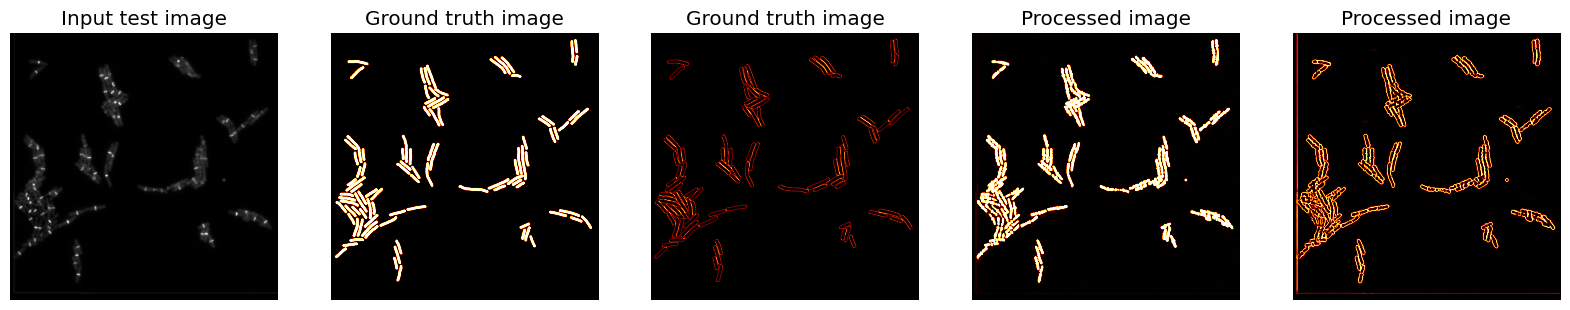

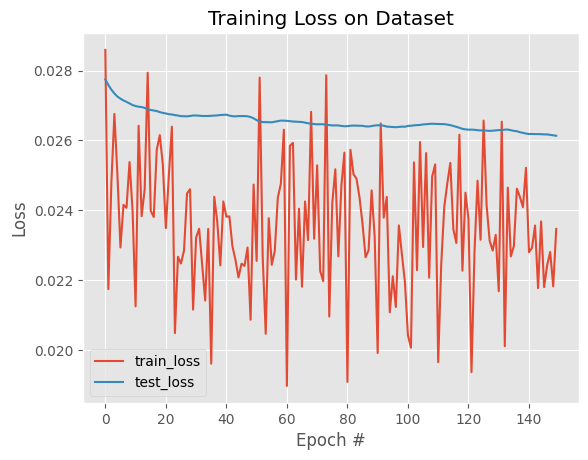

In [126]:
#@markdown ## Set up training parameters


# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model

# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.000001 #@param {type:"number"}
NUM_EPOCHS = 150 #@param {type:"integer"}
BATCH_SIZE = 20 #@param {type:"integer"}
# define the input image dimensions
INPUT_IMAGE_WIDTH = 256 #@param {type:"integer"}
INPUT_IMAGE_HEIGHT = 256 #@param {type:"integer"}
CLASSES=3
# Training data files
TRAIN_IM = "/content/drive/Multilabel_U-Net_dataset_B.subtilis/training/source" #@param {type:"string"}
TRAIN_MASK = "/content/Multilabel_U-Net_dataset_B.subtilis/training/target_boundaries" #@param {type:"string"}
# Test data files
TEST_IM = "/content/Multilabel_U-Net_dataset_B.subtilis/test/source" #@param {type:"string"}
TEST_MASK = "/content/Multilabel_U-Net_dataset_B.subtilis/test/target_boundaries" #@param {type:"string"}


#@markdown ### Path to the directory to save the new model

# define the path to the base output directory
BASE_OUTPUT = "/content/bioimageio_finetuning/" #@param {type:"string"}
os.makedirs(BASE_OUTPUT, exist_ok=True)
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "finetuned_bioimageio.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

#-----
#del model_instance
#del finetuned_model
torch.cuda.empty_cache()

#gc.collect()


finetuned_model, H = finetune_bioimageio_model(model, TRAIN_IM, TRAIN_MASK, TEST_IM, TEST_MASK,
                                          BASE_OUTPUT, NUM_EPOCHS=NUM_EPOCHS, INIT_LR=INIT_LR, BATCH_SIZE=BATCH_SIZE,
                                          INPUT_IMAGE_WIDTH=INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT=INPUT_IMAGE_HEIGHT,
                                               CLASSES=3)

# Save the model in two different formats
MODEL_STETEDICT_PATH = os.path.join(BASE_OUTPUT, "finetuned_bioimageio_statedict_model.pth")
torch.save(finetuned_model.cpu().state_dict(),MODEL_STETEDICT_PATH)
## Use the following to convert the model into torchscript
MODEL_TORCHSCRIPT_PATH = os.path.join(BASE_OUTPUT, "finetuned_bioimageio_torchscript_model.pt")
with torch.no_grad():
    # load input and expected output data
    input_data = [np.load(inp).astype("float32") for inp in model.test_inputs]
    input_data = [torch.from_numpy(inp) for inp in input_data]
    scripted_model = torch.jit.trace(finetuned_model.cpu(), input_data)
    scripted_model.save(MODEL_TORCHSCRIPT_PATH)

# plot the training loss
plt.style.use("ggplot")
plt.figure(figsize=(20, 10))
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

## 6. Create a BioImage Model Zoo model

Let's recreate a model based on parts of the loaded model description from above!

`bioimageio.core` also implements functionality to create a model package compatible with the [BioImnageIO Model Spec](https://bioimage.io/docs/#/bioimageio_model_spec) ready to be shared via the [Bioimage Model Zoo](https://bioimage.io/#/).
Here, we will use this functionality to create two models, one that adds thresholding as post-processing to the outputs and another one that also adds weights in torchscript format.

For this we are using thre previous model including some changes as new postprocessing pipelines.

In [79]:
## TODO
# ------
# information about the model

#@markdown ##Export the new model to the bioimage model zoo format

Trained_model_name = "My new model" #@param {type:"string"}
Trained_model_description = "Model finetuned" #@param {type:"string"}

#@markdown ### Choose a test image
path2image = "/content/drive/Multilabel_U-Net_dataset_B.subtilis/test/source/test_9.tif"  #@param {type:"string"}
training_data_bioimnageio_id = "zero/dataset_u-net_2d_multilabel_deepbacs"  #@param {type:"string"}
# create the training data
training_data = {"id": training_data_bioimnageio_id}
#training_data = {"source": training_data_source,
#                  "description": training_data_description}

#@markdown ### Path where the new model checkpoint is saved
BASE_OUTPUT = "/content/bioimageio_finetuning/" #@param {type:"string"}
MODEL_TORCHSCRIPT_PATH = os.path.join(BASE_OUTPUT, "finetuned_bioimageio_torchscript_model.pt")
output_path = os.path.join(BASE_OUTPUT, "finetuned_bioimageio_model.zip")

authors = [{"name": model.authors[0].name, "affiliation": model.authors[0]}]
Trained_model_license = model.license
readme_path = model.documentation
citations = [{'text': i.text, 'url': i.url} for i in model.cite]


axes = ''
for i in model.inputs[0].axes:
  axes = axes+i
preprocessing = [[{"name": prep.name, "kwargs": prep.kwargs} for prep in inp.preprocessing] for inp in model.inputs]
kwargs = dict(
  input_names = [model.inputs[0].name],
  input_data_range = [[-np.inf, np.inf]],
  input_axes = [axes],
  input_min_shape = [model.inputs[0].shape.min],
  input_step =[ model.inputs[0].shape.step],
  preprocessing =  preprocessing)

axes = ''
for i in model.outputs[0].axes:
  axes = axes+i
# There is no postprocessing here
#postprocessing = [[{"name": post.name, "kwargs": post.kwargs} for post in inp.postprocessing] for inp in model.outputs]

output_spec = dict(
  output_names = [model.outputs[0].name],
  output_data_range =  [[-np.inf, np.inf]],
  output_axes = [axes],
  #postprocessing = postprocessing,
  output_reference =[ model.outputs[0].shape.reference_tensor],
  output_scale = [model.outputs[0].shape.scale], # consider changing it if the input has more than one channel
  output_offset =[ model.outputs[0].shape.offset]
)
kwargs.update(output_spec)


new_input_path = f"{BASE_OUTPUT}/new_test_input.npy"
test_im = imread(path2image)
test_im = test_im[-256:, :256]
test_im = np.expand_dims(test_im, [0,1])
np.save(new_input_path, test_im)

new_output_path = f"{BASE_OUTPUT}/new_test_output.npy"
np.save(new_output_path, np.float32(test_im))

model_source = get_architecture_source("affable-shark")

# we create the model, process the input image and create the model again with the correct output.
for i in range(2):
  build_model(
      name = Trained_model_name,
      description = Trained_model_description,
      # additional metadata about authors, licenses, citation etc.
      authors = authors,
      license = Trained_model_license,
      documentation = readme_path,
      # the weight file and the type of the weights
      weight_uri = MODEL_TORCHSCRIPT_PATH,
      weight_type = "torchscript",
      # the test input and output data as well as the description of the tensors
      # these are passed as list because we support multiple inputs / outputs per model
      test_inputs = [new_input_path],
      test_outputs =  [new_output_path],
      # where to save the model zip, how to call the model and a short description of it
      output_path = output_path,
      tags=["in-silico-labeling","pytorch", "cyclegan", "conditional-gan",
            "zerocostdl4mic", "deepimagej", "actin", "dapi", "cells", "nuclei",
            "fluorescence-light-microscopy", "2d"],  # the tags are used to make models more findable on the website
      cite = citations,
      training_data = training_data,
      add_deepimagej_config=True,
      **kwargs
      )
  if i == 0:
    predict_image(model_rdf = output_path, inputs = new_input_path, outputs = new_output_path)

# check that the model works for keras and tensorflow
res = test_model(output_path, weight_format="torchscript")
success = True
if res[-1]["error"] is not None:
  success = False
  print("test-model failed:", res[-1]["error"])

if success:
  print("The bioimage.io model was successfully exported to", output_path)
else:
  print("The bioimage.io model was exported to", output_path)
  print("Some tests of the model did not work!l.")
  print("You can still download and test the model, but it may not work as expected.")




computing dataset statistics: 0it [00:00, ?it/s]
computing dataset statistics: 0it [00:00, ?it/s]


The bioimage.io model was successfully exported to /content/drive/MyDrive/HENRIQUES LAB/PROJECTS/BIOIMAGE MODEL ZOO/EBI-Microscopy/bioimageio_finetuning/finetuned_bioimageio_model.zip
